In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [2]:
df = pd.read_csv('ficheros/limpieza_sin_nulos.csv', index_col=0)

In [3]:
# lo primero que vamos a hacer es calcular el porcentaje de nulos que tenemos para cada columna
(df.isnull().sum() / df.shape[0]) * 100

Last_name                     47.266881
First_name                    47.266881
EmpID                          0.000000
GenderID                       0.000000
EmpStatusID                    0.000000
DeptID                         0.000000
PerfScoreID                    9.324759
FromDiversityJobFairID        49.839228
Salary                         0.000000
Termd                          0.000000
Position                       0.000000
State                          0.000000
Zip                            0.000000
DOB                            0.000000
MaritalDesc                    0.000000
CitizenDesc                   15.434084
HispanicLatino                 0.000000
RaceDesc                      27.009646
DateofHire                    26.688103
DateofTermination             67.202572
TermReason                    19.292605
EmploymentStatus               0.000000
Department                    40.514469
ManagerID                      2.572347
RecruitmentSource             14.469453


In [4]:
# lo convertimos a DataFrame
df_nulos = pd.DataFrame((df.isnull().sum() / df.shape[0]) * 100, columns = ["%_nulos"])

# filtramos el DataFrame para quedarnos solo con aquellas columnas que tengan nulos
df_nulos[df_nulos["%_nulos"] > 0]

,%_nulos
Last_name,47.266881
First_name,47.266881
PerfScoreID,9.324759
FromDiversityJobFairID,49.839228
CitizenDesc,15.434084
RaceDesc,27.009646
DateofHire,26.688103
DateofTermination,67.202572
TermReason,19.292605
Department,40.514469


In [5]:
#Borramos:
# Manager nombre y apellido - No existe correspondencia entre el Manager ID y el Nombre y Apellido del Manager por lo que no podríamos completar los valores faltantes del nombre y apellido del manager
# JobDiversity - La info ya la tenemos en RecruitmentSource 
#"PerfScoreID" - La info la tenemos en PerformanceScore

borrar_cat = ["ManagerFirstName", "ManagerLastName", "FromDiversityJobFairID", "PerfScoreID"]
df.drop(columns = borrar_cat, axis=1, inplace=True)
df.columns

Index(['Last_name', 'First_name', 'EmpID', 'GenderID', 'EmpStatusID', 'DeptID',
       'Salary', 'Termd', 'Position', 'State', 'Zip', 'DOB', 'MaritalDesc',
       'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire',
       'DateofTermination', 'TermReason', 'EmploymentStatus', 'Department',
       'ManagerID', 'RecruitmentSource', 'PerformanceScore',
       'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
       'LastPerformanceReview_Date', 'DaysLateLast30', 'Absences', 'Age'],
      dtype='object')

# Variable categóricas

Gestión de nulos en categóricas:

- ManagerID - Unknown
- Last Name, First Name - Unknown
- CitizenDesc
- RaceDesc
- DateofTermination: Termd == 1 -- 2 valores = "31/12/2023"
- DateofTermination: Termd ==0 -- 207 valores activos = "00/00/0000"
- TermReason - Unknown
- Department - Completar con diccionario (dept_dic)
- Recruitment Source _ unknown
- LastPerformanceReview_Date - Lo dejamos en nulo

In [6]:
# Obtenemos la lista de columnas categóricas que tienen nulos
nulos_esta_cat = df[df.columns[df.isnull().any()]].select_dtypes(include = "O").columns
print("Las columnas categóricas que tienen nulos son : \n ")
print(nulos_esta_cat)

Las columnas categóricas que tienen nulos son : 
 
Index(['Last_name', 'First_name', 'CitizenDesc', 'RaceDesc', 'DateofHire',
       'DateofTermination', 'TermReason', 'Department', 'RecruitmentSource',
       'LastPerformanceReview_Date'],
      dtype='object')


In [7]:
# sacamos el 'value_counts()' de cada una de las columnas categóricas que tienen nulos para saber como es la distribución de sus categorías
for col in nulos_esta_cat:
    print(f"La distribución de las categorías para la columna {col.upper()}")
    display(df[col].value_counts() / df.shape[0])
    print("..........")

La distribución de las categorías para la columna LAST_NAME


Nguyen      0.006431
Anderson    0.006431
Robinson    0.006431
Ndzi        0.006431
Miller      0.006431
              ...   
Good        0.003215
Goyal       0.003215
Gross       0.003215
Gruber      0.003215
Zima        0.003215
Name: Last_name, Length: 159, dtype: float64

..........
La distribución de las categorías para la columna FIRST_NAME


 Susan         0.009646
 Jennifer      0.006431
 Alex          0.006431
 Peter         0.006431
 Jason         0.006431
                 ...   
 Hans          0.003215
 Christie      0.003215
 Kara          0.003215
 Anthony       0.003215
 Catherine     0.003215
Name: First_name, Length: 155, dtype: float64

..........
La distribución de las categorías para la columna CITIZENDESC


US Citizen             0.803859
Eligible NonCitizen    0.032154
Non-Citizen            0.009646
Name: CitizenDesc, dtype: float64

..........
La distribución de las categorías para la columna RACEDESC


White                               0.434084
Black or African American           0.192926
Asian                               0.064309
Two or more races                   0.028939
American Indian or Alaska Native    0.006431
Hispanic                            0.003215
Name: RaceDesc, dtype: float64

..........
La distribución de las categorías para la columna DATEOFHIRE


2011-01-10    0.038585
2015-01-05    0.032154
2011-09-26    0.028939
2011-07-05    0.025723
2011-05-16    0.025723
                ...   
2011-03-07    0.003215
2012-07-09    0.003215
2012-04-30    0.003215
2011-01-21    0.003215
2010-04-10    0.003215
Name: DateofHire, Length: 87, dtype: float64

..........
La distribución de las categorías para la columna DATEOFTERMINATION


2018-08-19    0.006431
2013-04-01    0.006431
2012-09-24    0.006431
2016-05-17    0.006431
2015-09-07    0.006431
                ...   
2014-01-11    0.003215
2011-05-30    0.003215
2015-03-15    0.003215
2015-06-25    0.003215
2015-09-29    0.003215
Name: DateofTermination, Length: 94, dtype: float64

..........
La distribución de las categorías para la columna TERMREASON


N/A-StillEmployed                   0.553055
Another position                    0.035370
unhappy                             0.032154
hours                               0.025723
more money                          0.025723
attendance                          0.019293
career change                       0.019293
return to school                    0.016077
relocation out of area              0.016077
military                            0.012862
performance                         0.012862
no-call, no-show                    0.009646
retiring                            0.009646
maternity leave - did not return    0.006431
Learned that he is a gangster       0.003215
Fatal attraction                    0.003215
medical issues                      0.003215
gross misconduct                    0.003215
Name: TermReason, dtype: float64

..........
La distribución de las categorías para la columna DEPARTMENT


Production              0.398714
IT/IS                   0.093248
Sales                   0.061093
Software Engineering    0.022508
Admin Offices           0.016077
Executive Office        0.003215
Name: Department, dtype: float64

..........
La distribución de las categorías para la columna RECRUITMENTSOURCE


Indeed                     0.231511
LinkedIn                   0.218650
Google Search              0.118971
Diversity Job Fair         0.090032
Employee Referral          0.090032
CareerBuilder              0.057878
Website                    0.038585
Other                      0.006431
On-line Web application    0.003215
Name: RecruitmentSource, dtype: float64

..........
La distribución de las categorías para la columna LASTPERFORMANCEREVIEW_DATE


1/14/2019    0.045016
2/18/2019    0.032154
1/28/2019    0.028939
1/21/2019    0.025723
2/25/2019    0.022508
               ...   
5/15/2012    0.003215
3/6/2011     0.003215
1/20/2015    0.003215
4/29/2016    0.003215
2/1/2019     0.003215
Name: LastPerformanceReview_Date, Length: 117, dtype: float64

..........


In [8]:
# 1. Unknowns
# Columnas cuyos nulos queremos reemplazar por "Unknown"
columnas_desconocido = ["ManagerID", "Last_name","First_name", "CitizenDesc", "RaceDesc", "TermReason","RecruitmentSource"]

# iteramos por la lista de columnas a las que le vamos a cambiar los nulos por "Uknown"
for columna in columnas_desconocido:
    
    # reemplazamos los nulos por el valor Unknown para cada una de las columnas de la lista
    df[columna] = df[columna].fillna("Unknown")
    
# comprobamos si quedan nulos en las columnas categóricas. 
print("Después del reemplazo usando 'fillna' quedan los siguientes nulos")
df[columnas_desconocido].isnull().sum()

Después del reemplazo usando 'fillna' quedan los siguientes nulos


ManagerID            0
Last_name            0
First_name           0
CitizenDesc          0
RaceDesc             0
TermReason           0
RecruitmentSource    0
dtype: int64

In [9]:
#2. Creamos un diccionario para completar los valores nulos de departamento deacuerdo con la información en el Dept.ID
dept_dic = {1: "Admin Offices" , 2: "Executive Office", 3: "IT/IS", 4: "Software Engineer", 5: "Production", 6: "Sales"}

#Reemplazamos los valores deacuerdo al diccionario
df["Department"] = df["DeptID"].replace(dept_dic)

#Verificamos que no quedan nulos
df["Department"].isnull().sum()

0

In [10]:
#3. Date of termination: 1. Cambiar a 31/12/2023" los 2 valores nulos para aquellos trabajadores que se marcharon (Termd== 0 ) y para los que aún isugen trabajando (Termd==0), cambiar los nulos por "00/00/0000"

#Cambiamos todos los nulos a 0000.00.00
df["DateofTermination"] = df["DateofTermination"].fillna("0000-00-00") 

#3.Verificamos que se han hecho bien los cambios
df["DateofTermination"].value_counts()

0000-00-00    209
2013-04-01      2
2012-09-24      2
2018-08-19      2
2016-05-17      2
             ... 
2014-01-11      1
2011-05-30      1
2015-03-15      1
2015-06-25      1
2015-09-29      1
Name: DateofTermination, Length: 95, dtype: int64

In [11]:
#3.b.Ahora cambiamos la fecha de los 2 que ya no están en la empresa y que teníamo valor nulo (ahora convertido a 0000-00-00)
df[(df["Termd"]== 1) & (df["DateofTermination"] == "0000-00-00")]

,Last_name,First_name,EmpID,GenderID,EmpStatusID,DeptID,Salary,Termd,Position,State,Zip,DOB,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Age
27,Unknown,Unknown,10175,1,3,5,"74,312.00",1,Production Manager,MA,1901,1970-03-10,Single,US Citizen,No,Asian,2013-09-30,0000-00-00,retiring,Voluntarily Terminated,Production,2.0,Indeed,Fully Meets,3.39,3,NaN,2/20/2014,NaN,14,53
132,Unknown,Unknown,10182,0,1,1,"49,920.00",1,Administrative Assistant,MA,2170,1985-09-16,Married,US Citizen,No,Black or African American,2015-02-16,0000-00-00,"no-call, no-show",Terminated for Cause,Admin Offices,1.0,Indeed,Fully Meets,3.24,3,4.0,4/15/2015,0.0,6,38


In [12]:
#Cambiamos estos 2 a fecha 31-12-2023
df.loc[(df['DateofTermination'] == '0000-00-00') & (df["Termd"] == 1), 'DateofTermination'] = '2023-12-31'

In [13]:
#Verificamos que se han realizado los cambios
df["DateofTermination"].value_counts().head(40)

0000-00-00    207
2013-04-01      2
2012-09-24      2
2018-08-19      2
2016-05-17      2
2015-09-07      2
2014-04-04      2
2023-12-31      2
2013-06-18      2
2015-11-04      2
2012-02-08      1
2011-10-22      1
2016-01-15      1
2018-04-07      1
2015-08-15      1
2018-06-04      1
2013-02-04      1
2012-11-30      1
2016-05-18      1
2018-11-10      1
2015-10-25      1
2015-09-15      1
2017-12-28      1
2016-05-01      1
2014-01-12      1
2013-08-19      1
2018-05-01      1
2016-05-25      1
2016-01-26      1
2018-07-30      1
2018-08-13      1
2016-11-11      1
2016-02-21      1
2015-06-27      1
2012-05-14      1
2014-05-15      1
2015-09-01      1
2012-01-02      1
2016-02-08      1
2017-02-22      1
Name: DateofTermination, dtype: int64

## Variables numéricas

In [14]:
# Obtenemos la lista de columnas numericas que tienen nulos
nulos_esta_num = df[df.columns[df.isnull().any()]].select_dtypes(include = np.number).columns
print("Las columnas numéricas que tienen nulos son : \n ")
print(nulos_esta_num)

Las columnas numéricas que tienen nulos son : 
 
Index(['SpecialProjectsCount', 'DaysLateLast30'], dtype='object')


In [15]:
df[nulos_esta_num].isnull().sum() 

SpecialProjectsCount    113
DaysLateLast30          120
dtype: int64

In [16]:
# Calculamos el número de nulos que tenemos en cada una de las columnas numericas
df[nulos_esta_num].isnull().sum() / df.shape[0]

SpecialProjectsCount    0.363344
DaysLateLast30          0.385852
dtype: float64

Podemos ver los valores atipicos con diagrama de boxplot 

In [17]:
df["DaysLateLast30"].value_counts()
#Los nulos a 0.0

0.0    175
4.0      5
2.0      4
6.0      3
3.0      2
5.0      2
Name: DaysLateLast30, dtype: int64

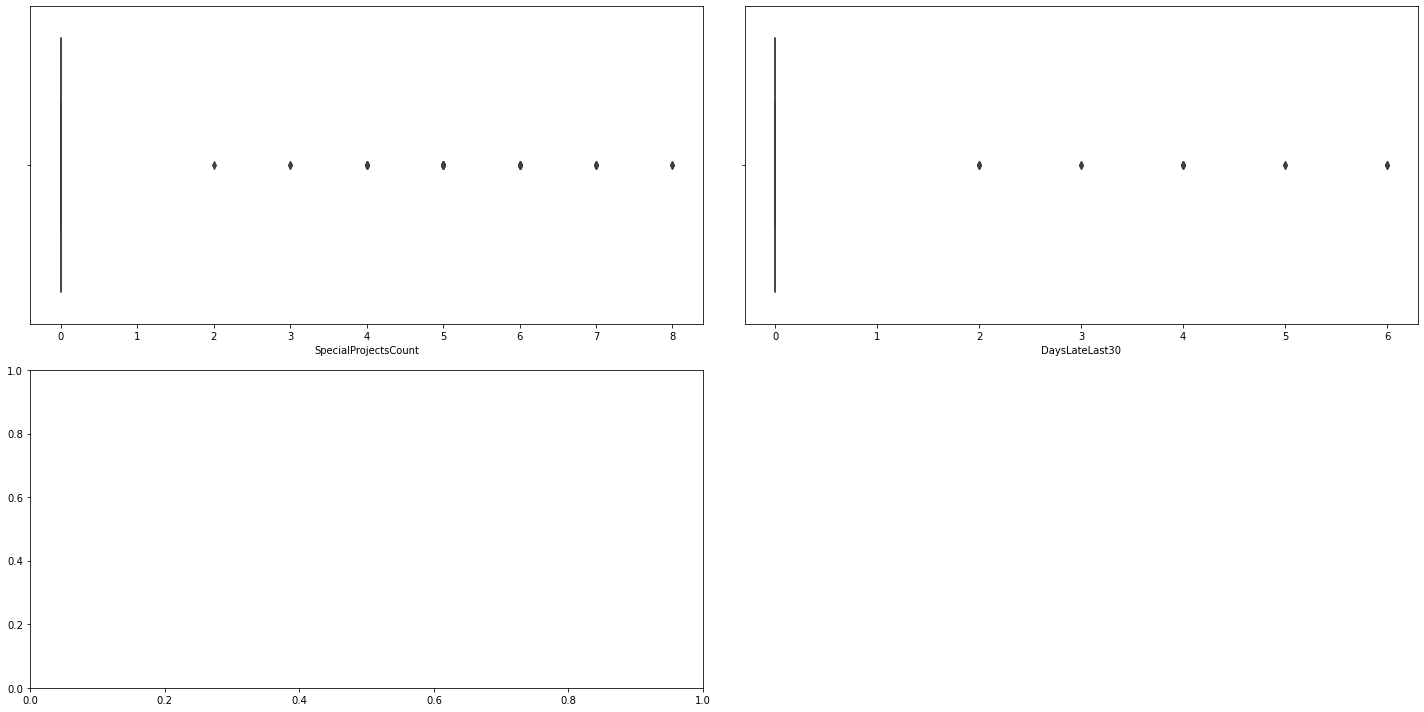

In [21]:
# Vemos los atípos de las columnas con nulos 

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10)) 

axes = axes.flat

for indice, col in enumerate(nulos_esta_num):
    sns.boxplot(x = col, data = df, ax = axes[indice])
    
plt.tight_layout()
fig.delaxes(axes[-1]);

Aquellas columnas que tienen valores por debajo del 5-10% podemos optar por reemplazar por la media o mediana
 - Si la muestra tiene valores atipicos, la mediana es la opcion, de lo contrario podemos usar la media


In [ ]:
- 'SpecialProjectsCount'
- 'DaysLateLast30'

In [23]:
#ITERATIVE IMPUTER

imputer_iterative = IterativeImputer(max_iter =20, random_state=42)
imputer_iterative_imputado = imputer_iterative.fit_transform(df[['SpecialProjectsCount', 'DaysLateLast30']])
df[['SpecialProjectsCount_iterative', 'DaysLateLast30_iterative']] = imputer_iterative_imputado

In [24]:
#KNN IMPUTER
imputer_knn = KNNImputer(n_neighbors=5)
imputer_knn_imputado = imputer_knn.fit_transform(df[['SpecialProjectsCount', 'DaysLateLast30']])
df[['SpecialProjectsCount_knn', 'DaysLateLast30_knn']] = imputer_knn_imputado

In [26]:
#Comparamos las estadísticas generadas de por el iterative y el knn para decidir cuál coger (aquel cuya media y mediana sea más parecida a la original- En la columna con valores atípicos cogemos aquel cuya mediana sea más parecida a la original)
df.describe()[['SpecialProjectsCount','SpecialProjectsCount_iterative', 'SpecialProjectsCount_knn', 'DaysLateLast30','DaysLateLast30_iterative','DaysLateLast30_knn']].T

,count,mean,std,min,25%,50%,75%,max
SpecialProjectsCount,198.0,1.000000,2.170405,0.0,0.0,0.0,0.000000,8.0
SpecialProjectsCount_iterative,311.0,0.999976,1.730187,0.0,0.0,0.0,1.000268,8.0
SpecialProjectsCount_knn,311.0,0.995498,1.730517,0.0,0.0,0.0,1.000000,8.0
DaysLateLast30,191.0,0.324607,1.151371,0.0,0.0,0.0,0.000000,6.0
DaysLateLast30_iterative,311.0,0.324598,0.901387,0.0,0.0,0.0,0.324598,6.0
DaysLateLast30_knn,311.0,0.254359,0.912002,0.0,0.0,0.0,0.000000,6.0


In [28]:
#Nos quedamos con los iterative cuyas medias y medianas coinciden con el original

#Quitamos las columnas originales y las de aquellos métodos q están más alejados de la media y medianas de las originales
df.drop(['SpecialProjectsCount', 'SpecialProjectsCount_knn', 'DaysLateLast30','DaysLateLast30_knn'], axis =1, inplace=True)

In [29]:
df.columns

Index(['Last_name', 'First_name', 'EmpID', 'GenderID', 'EmpStatusID', 'DeptID',
       'Salary', 'Termd', 'Position', 'State', 'Zip', 'DOB', 'MaritalDesc',
       'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire',
       'DateofTermination', 'TermReason', 'EmploymentStatus', 'Department',
       'ManagerID', 'RecruitmentSource', 'PerformanceScore',
       'EngagementSurvey', 'EmpSatisfaction', 'LastPerformanceReview_Date',
       'Absences', 'Age', 'SpecialProjectsCount_iterative',
       'DaysLateLast30_iterative'],
      dtype='object')

In [31]:
keys = ['Last_name', 'First_name', 'EmpID', 'GenderID', 'EmpStatusID', 'DeptID',
        'Salary', 'Termd', 'Position', 'State', 'Zip', 'DOB', 'MaritalDesc',
        'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire',
        'DateofTermination', 'TermReason', 'EmploymentStatus', 'Department',
        'ManagerID', 'RecruitmentSource', 'PerformanceScore',
        'EngagementSurvey', 'EmpSatisfaction', 'LastPerformanceReview_Date',
        'Absences', 'Age', 'SpecialProjectsCount_iterative',
        'DaysLateLast30_iterative']

result_dict = {key: key for key in keys}

result_dict

{'Last_name': 'Last_name',
 'First_name': 'First_name',
 'EmpID': 'EmpID',
 'GenderID': 'GenderID',
 'EmpStatusID': 'EmpStatusID',
 'DeptID': 'DeptID',
 'Salary': 'Salary',
 'Termd': 'Termd',
 'Position': 'Position',
 'State': 'State',
 'Zip': 'Zip',
 'DOB': 'DOB',
 'MaritalDesc': 'MaritalDesc',
 'CitizenDesc': 'CitizenDesc',
 'HispanicLatino': 'HispanicLatino',
 'RaceDesc': 'RaceDesc',
 'DateofHire': 'DateofHire',
 'DateofTermination': 'DateofTermination',
 'TermReason': 'TermReason',
 'EmploymentStatus': 'EmploymentStatus',
 'Department': 'Department',
 'ManagerID': 'ManagerID',
 'RecruitmentSource': 'RecruitmentSource',
 'PerformanceScore': 'PerformanceScore',
 'EngagementSurvey': 'EngagementSurvey',
 'EmpSatisfaction': 'EmpSatisfaction',
 'LastPerformanceReview_Date': 'LastPerformanceReview_Date',
 'Absences': 'Absences',
 'Age': 'Age',
 'SpecialProjectsCount_iterative': 'SpecialProjectsCount_iterative',
 'DaysLateLast30_iterative': 'DaysLateLast30_iterative'}

In [32]:
nuevas_columnas = {'Last_name': 'Last_name',
 'First_name': 'First_name',
 'EmpID': 'EmpID',
 'GenderID': 'GenderID',
 'EmpStatusID': 'EmpStatusID',
 'DeptID': 'DeptID',
 'Salary': 'Salary',
 'Termd': 'Termd',
 'Position': 'Position',
 'State': 'State',
 'Zip': 'Zip',
 'DOB': 'DOB',
 'MaritalDesc': 'MaritalDesc',
 'CitizenDesc': 'CitizenDesc',
 'HispanicLatino': 'HispanicLatino',
 'RaceDesc': 'RaceDesc',
 'DateofHire': 'DateofHire',
 'DateofTermination': 'DateofTermination',
 'TermReason': 'TermReason',
 'EmploymentStatus': 'EmploymentStatus',
 'Department': 'Department',
 'ManagerID': 'ManagerID',
 'RecruitmentSource': 'RecruitmentSource',
 'PerformanceScore': 'PerformanceScore',
 'EngagementSurvey': 'EngagementSurvey',
 'EmpSatisfaction': 'EmpSatisfaction',
 'LastPerformanceReview_Date': 'LastPerformanceReview_Date',
 'Absences': 'Absences',
 'Age': 'Age',
 'SpecialProjectsCount_iterative': 'SpecialProjectsCount',
 'DaysLateLast30_iterative': 'DaysLateLast30'}

In [33]:
df.rename(columns = nuevas_columnas, inplace = True)

In [35]:
df.head().T

,0,1,2,3,4
Last_name,Adinolfi,Unknown,Akinkuolie,Alagbe,Anderson
First_name,Wilson K,Unknown,Sarah,Trina,Carol
EmpID,10026,10084,10196,10088,10069
GenderID,1,1,0,0,0
EmpStatusID,1,3,3,1,3
DeptID,5,3,5,5,5
Salary,"62,506.00","104,437.00","64,955.00","64,991.00","50,825.00"
Termd,0,1,1,0,1
Position,Production Technician I,Sr. DBA,Production Technician II,Production Technician I,Production Technician I
State,MA,MA,MA,MA,MA


In [36]:
df.to_csv("limpieza_con_nulos.csv")

In [2]:
df = pd.read_csv('limpieza_con_nulos.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  311 non-null    int64  
 1   Last_name                   311 non-null    object 
 2   First_name                  311 non-null    object 
 3   EmpID                       311 non-null    int64  
 4   GenderID                    311 non-null    int64  
 5   EmpStatusID                 311 non-null    int64  
 6   DeptID                      311 non-null    int64  
 7   Salary                      311 non-null    object 
 8   Termd                       311 non-null    int64  
 9   Position                    311 non-null    object 
 10  State                       311 non-null    object 
 11  Zip                         311 non-null    int64  
 12  DOB                         311 non-null    object 
 13  MaritalDesc                 311 non

In [6]:
df['HispanicLatino'].value_counts()

No     282
Yes     27
no       1
yes      1
Name: HispanicLatino, dtype: int64

In [7]:
mapa = {'yes' : 'Yes', 'no' : 'No'}

In [8]:
df['HispanicLatino'] = df['HispanicLatino'].replace(mapa)

In [9]:
df['HispanicLatino'].value_counts()

No     283
Yes     28
Name: HispanicLatino, dtype: int64

In [2]:
df = pd.read_csv('limpieza_con_nulos.csv')

In [3]:
df['MaritalDesc'].value_counts()

Single       137
Married      124
Divorced      30
Separated     12
Widowed        8
Name: MaritalDesc, dtype: int64

In [4]:
mapa_2 = {'Separated' : 'Divorced'}

In [5]:
df['MaritalDesc'] = df['MaritalDesc'].replace(mapa_2)

In [6]:
df['MaritalDesc'].value_counts()

Single      137
Married     124
Divorced     42
Widowed       8
Name: MaritalDesc, dtype: int64

In [10]:
df.to_csv("limpieza_con_nulos.csv")

In [4]:
df = pd.read_csv('limpieza_con_nulos.csv', index_col=0)

In [8]:
df.drop('Unnamed: 0', axis=1,  inplace=True)

In [10]:
df.to_csv("limpieza_con_nulos.csv")